In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
df_src = pd.read_csv('data/titanic/train.csv')
df_src.head(1)
#df_src.isna().sum()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


In [10]:
def prepare_dataframe(df, train = True):
    if train:
        y = df['Survived']
        X = df.drop(['Survived'], axis = 1)
    else: 
        y = None
        X = df 
    X = X.fillna({'Age': X.Age.median()})
    X = X.fillna(0)
    X.set_index('PassengerId', inplace=True)
    X = X[['Pclass', 'Sex', 'Age', 'Fare']]
    X = pd.get_dummies(X)
    X = X.drop('Sex_male', axis=1)
    return X, y

In [11]:
X, y = prepare_dataframe(df_src, train = True)
X.head()

,Pclass,Age,Fare,Sex_female
PassengerId,,,,
1,3,22.0,7.2500,0
2,1,38.0,71.2833,1
3,3,26.0,7.9250,1
4,1,35.0,53.1000,1
5,3,35.0,8.0500,0


In [12]:
# более сильную GridSearch
clf = RandomForestClassifier()
params = {'n_estimators': [1,3,5,7,9,10,15,20],
          'criterion' : ['gini','entropy'],
          'max_depth': range(2,10),
          'min_samples_split': [2,3,4,5,7,10,15],
          'min_samples_leaf' : [1,2,3,4,5,7,10,15],
          'bootstrap': [True, False] }

search = GridSearchCV(clf, params, cv = 5)
search.fit(X,y)


/home/sda/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=Fa...
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid=

In [13]:
search.best_params_, search.best_score_

({'bootstrap': False,
  'criterion': 'entropy',
  'max_depth': 9,
  'min_samples_leaf': 2,
  'min_samples_split': 10,
  'n_estimators': 7},
 0.8439955106621774)

In [14]:
search.best_estimator_.feature_importances_

array([0.13553177, 0.19286501, 0.29515216, 0.37645105])

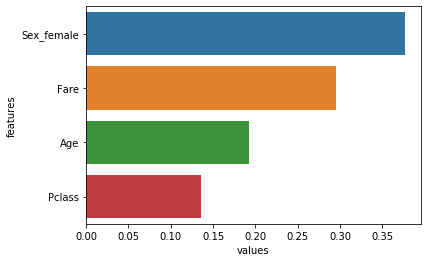

In [15]:
### хочу построить красивую картинку
features = pd.DataFrame({'features': X.columns, 'values': search.best_estimator_.feature_importances_})\
                   .sort_values('values', ascending = False)
sns.barplot(features['values'], features['features'])


In [16]:
search.best_score_

0.8439955106621774

In [17]:
df_test = pd.read_csv('data/titanic/test.csv')
X_res, _ = prepare_dataframe(df_test, train = False)

X_res['Survived'] = search.best_estimator_.predict(X_res)
X_res[['Survived']].to_csv('data/titanic/result.csv')